# Tutorial 9.2: Normalizing Flows for image modeling

The most popular, current application of deep normalizing flows is to model datasets of images. As for other generative models, images are a good domain to start working on because (1) CNNs are widely studied and strong models exist, (2) images are high-dimensional and complex, and (3) images are discrete integers. In this tutorial, we will review current advances in normalizing flows for image modeling, and get hands-on experience on coding normalizing flows. Note that normalizing flows are commonly parameter heavy and therefore computationally expensive. We will use relatively simple and shallow flows to save computational cost and allow you to run the notebook on CPU, but keep in mind that a simple way to improve the scores of the flows we study here is to make them deeper. 

Throughout this notebook, we make use of [PyTorch Lightning](https://pytorch-lightning.readthedocs.io/en/latest/). The first cell imports our usual libraries.

In [1]:
## Standard libraries
import os
import json
import math
import time
import numpy as np 
import scipy.linalg

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateLogger, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial9"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0


We will use the MNIST dataset in this notebook. MNIST constitutes, despite its simplicity, a challenge for small generative models as it requires the global understanding of an image. At the same time, we can easily judge whether generated images come from the same distribution as the dataset (i.e. represent real digits), or not.

To deal better with the discrete nature of the images, we transform them from a range of 0-1 to a range of 0-255 as integers.

In [2]:
# Convert images from 0-1 to 0-255 (integers)
def discretize(sample):
    return (sample * 255).to(torch.int32)

# Transformations applied on each image => make them a tensor and discretize
transform = transforms.Compose([transforms.ToTensor(),
                                discretize])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = MNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
pl.seed_everything(42)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Loading the test set
test_set = MNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
# Note that for actually training a model, we will use different data loaders
# with a lower batch size.
train_loader = data.DataLoader(train_set, batch_size=256, shuffle=False, drop_last=False)
val_loader = data.DataLoader(val_set, batch_size=64, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=64, shuffle=False, drop_last=False, num_workers=4)

In addition, we will define below a function to simplify the visualization of images/samples. Some training examples of the MNIST dataset is shown below.

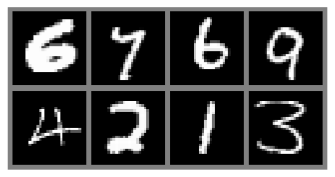

In [3]:
def show_imgs(imgs, title=None):
    # Form a grid of pictures (we use max. 4 columns)
    num_imgs = imgs.shape[0] if isinstance(imgs, torch.Tensor) else len(imgs)
    is_int = imgs.dtype==torch.int32 if isinstance(imgs, torch.Tensor) else imgs[0].dtype==torch.int32
    nrow = min(num_imgs, 4)
    ncol = int(math.ceil(num_imgs/nrow))
    imgs = torchvision.utils.make_grid(imgs, nrow=nrow, pad_value=128 if is_int else 0.5)
    np_imgs = imgs.cpu().numpy()
    # Plot the grid
    plt.figure(figsize=(1.5*nrow, 1.5*ncol))
    plt.imshow(np.transpose(np_imgs, (1,2,0)), interpolation='nearest')
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.show()
    plt.close()

show_imgs([train_set[i][0] for i in range(8)])

## Normalizing Flows on images

As a first step, we will implement a template of a normalizing flow in PyTorch Lightning. During training and validation, a normalizing flow performs density estimation in the forward direction. For this, we apply a series of flow transformations on the input $x$ and estimate the probability of the input by determining the probability of the transformed point $z$ given a prior, and the change of volume caused by the transformations. During inference, we can do both density estimation and sampling new points by inverting the flow transformations. Therefore, we define a function `_get_likelihood` which performs density estimation, and `sample` to generate new examples. The functions `training_step`, `validation_step` and `test_step` all make use of `_get_likelihood`. 

The standard metric used in generative models, and in particular normalizing flows, is bits per dimensions (bpd). Bpd is motivated from an information theory perspective and describes how many bits we would need to encode a particular example in our modeled distribution. The less bits we need, the more likely the example in our distribution. When we test for the bits per dimension of our test dataset, we can judge whether our model generalizes to new samples of the dataset and didn't memorize the training dataset. In order to calculate the bits per dimension score, we can rely on the negative log-likelihood and change the log base (as bits are binary while NLL is usually exponential):

$$\text{bpd} = \text{nll} \cdot \log_2\left(\exp(1)\right) \cdot \left(\prod d_i\right)^{-1}$$

where $d_1,...,d_K$ are the dimensions of the input. For images, this would be the height, width and channel number. In the original image space, MNIST examples have a bits per dimension score of 8 (we need 8 bits to encode each pixel). 

In [4]:
class ImageFlow(pl.LightningModule):
    
    def __init__(self, flows, import_samples=8):
        """
        Inputs:
            flows - A list of flows (each a nn.Module) that should be applied on the images. 
            import_samples - Number of importance samples to use during testing (see explanation below). Can be changed at any time
        """
        super().__init__()
        self.flows = nn.ModuleList(flows)
        self.import_samples = import_samples
        # Create prior distribution for final latent space
        self.prior = torch.distributions.normal.Normal(loc=0.0, scale=1.0)
        # Example input for visualizing the graph
        self.example_input_array = train_set[0][0].unsqueeze(dim=0)
        
        
    def forward(self, imgs):
        # The forward function is only used for visualizing the graph
        return self._get_likelihood(imgs)
    
    
    def encode(self, imgs):
        # Given a batch of images, return the latent representation z and ldj of the transformations
        z, ldj = imgs, torch.zeros(imgs.shape[0], device=self.device)
        for flow in self.flows:
            z, ldj = flow(z, ldj, reverse=False)
        return z, ldj
    
    
    def _get_likelihood(self, imgs, return_ll=False):
        """
        Given a batch of images, return the likelihood of those. 
        If return_ll is True, this function returns the log likelihood of the input.
        Otherwise, the ouptut metric is bits per dimension (scaled negative log likelihood)
        """
        z, ldj = self.encode(imgs)
        log_pz = self.prior.log_prob(z).sum(dim=[1,2,3])
        log_px = ldj + log_pz
        nll = -log_px
        # Calculating bits per dimension
        bpd = nll * np.log2(np.exp(1)) / np.prod(imgs.shape[1:])
        return bpd.mean() if not return_ll else log_px
        
        
    @torch.no_grad()
    def sample(self, img_shape, z_init=None):
        """
        Sample a batch of images from the flow.
        """
        # Sample latent representation from prior
        if z_init is None:
            z = self.prior.sample(sample_shape=img_shape).to(device)
        else:
            z = z_init.to(device)
        
        # Transform z to x by inverting the flows
        ldj = torch.zeros(img_shape[0], device=device)
        for flow in reversed(self.flows):
            z, ldj = flow(z, ldj, reverse=True)
        return z
    
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        # An scheduler is optional, but can help in flows to get the last bpd improvement
        scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.99)
        return [optimizer], [scheduler]
    
    
    def training_step(self, batch, batch_idx):
        # Normalizing flows are trained by maximum likelihood => return bpd
        loss = self._get_likelihood(batch[0])                             
        result = pl.TrainResult(minimize=loss)
        result.log('train_loss', loss, prog_bar=True)
        return result
    
    
    def validation_step(self, batch, batch_idx):
        loss = self._get_likelihood(batch[0])
        return {'val_loss': loss, 'checkpoint_on': loss, 'log': {'val_bpd': loss}}
    
    
    def test_step(self, batch, batch_idx):
        # Perform importance sampling during testing => estimate likelihood M times for each image
        samples = []
        for _ in range(self.import_samples):
            img_ll = self._get_likelihood(batch[0], return_ll=True)
            samples.append(img_ll)
        img_ll = torch.stack(samples, dim=-1)
        
        # To average the probabilities, we need to go from log-space to exp, and back to log.
        # Logsumexp provides us a stable implementation for this
        img_ll = torch.logsumexp(img_ll, dim=-1) - np.log(self.import_samples)
        
        # Calculate final bpd
        bpd = -img_ll * np.log2(np.exp(1)) / np.prod(batch[0].shape[1:])
        bpd = bpd.mean()
        
        result = pl.EvalResult()
        result.log("test_bpd", bpd)
        return result

The `test_step` function differs from the training and validation step that it makes use of importance sampling. We will discuss the motiviation and details behind this after understanding how flows model discrete images in continuous space. 

### Dequantization

Normalizing flows rely on the rule of change of variables, which is naturally defined in continuous space. Applying flows directly on discrete data leads to undesired density models where arbitrarly high likelihood are placed on a few, particular values. See the illustration below: 

<center><img src="dequantization_issue.svg" width="40%"/></center>

The black points represent the discrete points, and the green volume the density modeled by a normalizing flow in continuous space. The flow would continue to increase the likelihood for $x=0,1,2,3$ to infinity while having no volume on any other point. However, the learned density does not tell anything about the distribution among the discrete points. 

To prevent such degenerated solutions, a common solution is to add a small amount of noise to each discrete value, which is also referred to as dequantization.
Considering $x$ as an integer (as it is the case for images), the dequantized representation $v$ can be formulated as $v=x+u$ where $u\in[0,1)^D$. 
Thus, the discrete value $1$ is modeled by a distribution over the interval $[1.0, 2.0)$, the value $2$ by an volume over $[2.0, 3.0)$, etc.
Our objective of modeling $p(x)$ becomes:

$$\log p(x) = \log \mathbb{E}_{u\sim q(u|x)}\left[\frac{p(x+u)}{q(u|x)} \right]$$

with $q(u|x)$ being the noise distribution. For now, we assume it to be uniform.

In the following, we will implement Dequantization as a flow transformation itself. After adding noise to the discrete values, we additionally transform the volume into a Gaussian-like shape. This is done by scaling $x+u$ between $0$ and $1$, and applying the invert of the sigmoid function $\sigma(z)^{-1} = \log z - \log 1-z$. If we would not do this, we would face two problems: 
1. The input is scaled between 0 and 256 while the prior distribution is a Gaussian with mean $0$ and standard deviation $1$. In the first iterations after initializing the parameters of the flow, we would have extremely low likelihoods for large values like $256$. This would cause the training to diverge instantaneously.
2. As the output distribution is a Gaussian, it is beneficial for the flow to have a similarly shaped input distribution. This will reduce the modeling complexity that is required by the flow.

Overall, we can implement dequantization as follows:

In [5]:
class Dequantization(nn.Module):
    
    def __init__(self, alpha=1e-5, quants=256):
        """
        Inputs:
            alpha - small constant that is used to scale the original input. 
                    Prevents dealing with values very close to 0 and 1 when inverting the sigmoid
            quants - Number of possible discrete values (usually 256 for 8-bit image)
        """
        super().__init__()
        self.alpha = alpha
        self.quants = quants 
        
    def forward(self, z, ldj, reverse=False):
        if not reverse:
            z, ldj = self.dequant(z, ldj)
            z, ldj = self.sigmoid(z, ldj, reverse=True)
        else:
            z, ldj = self.sigmoid(z, ldj, reverse=False)
            z = z * self.quants
            ldj += np.log(self.quants) * np.prod(z.shape[1:])
            z = torch.floor(z).clamp(min=0, max=self.quants-1).to(torch.int32)
        return z, ldj
    
    def sigmoid(self, z, ldj, reverse=False):
        # Applies an invertible sigmoid transformation
        if not reverse:
            ldj += (-z-2*F.softplus(-z)).sum(dim=[1,2,3])
            z = torch.sigmoid(z)
        else:
            z = z * (1 - self.alpha) + 0.5 * self.alpha  # Scale to prevent boundaries 0 and 1
            ldj += np.log(1 - self.alpha) * np.prod(z.shape[1:])
            ldj += (-torch.log(z) - torch.log(1-z)).sum(dim=[1,2,3])
            z = torch.log(z) - torch.log(1-z)
        return z, ldj
    
    def dequant(self, z, ldj):
        # Transform discrete values to continuous volumes
        z = z.to(torch.float32)
        z = z + torch.rand_like(z).detach()
        z = z / self.quants
        ldj -= np.log(self.quants) * np.prod(z.shape[1:])
        return z, ldj

A good check whether a flow is correctly implemented or not, is to verify that it is invertible. Hence, we will dequantize a randomly chosen training image, and then quantize it again. We would expect that we would get the exact same image out:

In [6]:
## Testing invertibility of dequantization layer
pl.seed_everything(42)
orig_img = train_set[0][0].unsqueeze(dim=0)
ldj = torch.zeros(1,)
dequant_module = Dequantization()
deq_img, ldj = dequant_module(orig_img, ldj, reverse=False)
reconst_img, ldj = dequant_module(deq_img, ldj, reverse=True)

d1, d2 = torch.where(orig_img.squeeze() != reconst_img.squeeze())
if len(d1) != 0:
    print("Dequantization was not invertible.")
    for i in range(d1.shape[0]):
        print("Original value:", orig_img[0,0,d1[i], d2[i]].item())
        print("Reconstructed value:", reconst_img[0,0,d1[i], d2[i]].item())
else:
    print("Successfully inverted dequantization")

# Layer is not strictly invertible due to float precision constraints
# assert (orig_img == reconst_img).all().item()

Dequantization was not invertible.
Original value: 0
Reconstructed value: 1


In contrast to our expectation, the test fails. However, this is no reason to doubt our implementation here as only one single value is not equal to the original. This is caused due to numerical inaccuracies in the sigmoid invert. While the input space to the inverted sigmoid is scaled between 0 and 1, the output space is between $-\infty$ and $\infty$. And as we use 32 bits to represent the numbers (in addition to applying logs over and over again), such inaccuries can occur and should not be worrisome. Nevertheless, it is good to be aware of them. 

Finally, we can take our dequantization and actually visualize the distribution it transforms the discrete values into:

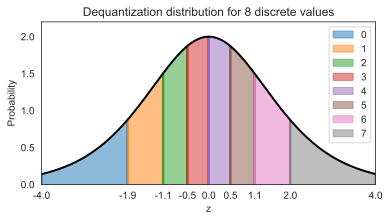

In [7]:
def visualize_dequantization(quants, prior=None):
    """
    Function for visualizing the dequantization values of discrete values in continuous space
    """
    # Prior over discrete values. If not given, a uniform is assumed
    if prior is None:
        prior = np.ones(quants, dtype=np.float32) / quants
    prior = prior / prior.sum() * quants # In the following, we assume 1 for each value means uniform distribution

    inp = torch.arange(-4, 4, 0.01).view(-1, 1, 1, 1) # Possible continuous values we want to consider
    ldj = torch.zeros(inp.shape[0])
    dequant_module = Dequantization(quants=quants)
    # Invert dequantization on continuous values to find corresponding discrete value
    out, ldj = dequant_module.forward(inp, ldj, reverse=True)
    inp, out, prob = inp.squeeze().numpy(), out.squeeze().numpy(), ldj.exp().numpy()
    prob = prob * prior[out] # Probability scaled by categorical prior
    
    # Plot volumes and continuous distribution
    sns.set_style("white")
    fig = plt.figure(figsize=(6,3))
    x_ticks = []
    for v in np.unique(out):
        indices = np.where(out==v)
        color = to_rgb("C%i"%v)
        plt.fill_between(inp[indices], prob[indices], np.zeros(indices[0].shape[0]), color=color+(0.5,), label=str(v))
        plt.plot([inp[indices[0][0]]]*2,  [0, prob[indices[0][0]]],  color=color)
        plt.plot([inp[indices[0][-1]]]*2, [0, prob[indices[0][-1]]], color=color)
        x_ticks.append(inp[indices[0][0]])
    x_ticks.append(inp.max())
    plt.xticks(x_ticks, ["%.1f"%x for x in x_ticks])
    plt.plot(inp,prob, color=(0.0,0.0,0.0))
    # Set final plot properties
    plt.ylim(0, prob.max()*1.1)
    plt.xlim(inp.min(), inp.max())
    plt.xlabel("z")
    plt.ylabel("Probability")
    plt.title("Dequantization distribution for %i discrete values" % quants)
    plt.legend()
    plt.show()
    plt.close()
    
visualize_dequantization(quants=8)

The visualized distribution show the sub-volumes that are assigned to the different discrete values. The value $0$ has its volume between $[-\infty, -1.9)$, the value $1$ is represented by the interval $[1.9, 1.1)$, etc. The volume for each discrete value has the same mass. That's why the volumes close to the center (e.g. 3 and 4) have a smaller area on the x-axis as others. 

Effectively, the consecutive normalizing flow models discrete images by the following objective:

$$\log p(x) = \log \mathbb{E}_{u\sim q(u|x)}\left[\frac{p(x+u)}{q(u|x)} \right] \geq \mathbb{E}_{u}\left[\log \frac{p(x+u)}{q(u|x)} \right]$$

Although normalizing flows are exact in likelihood, we have a lower bound. Specifically, this is an example of the Jensen inequality because we need to move the log into the expectation so we can use Monte-carlo estimates. In general, this bound is considerably smaller than the ELBO in variational autoencoders. Actually, we can reduce the bound ourselves by estimating the expectation not by one, but by $M$ samples. In other words, we can apply importance sampling which leads to the following inequality:

$$\log p(x) = \log \mathbb{E}_{u\sim q(u|x)}\left[\frac{p(x+u)}{q(u|x)} \right] \geq \mathbb{E}_{u}\left[\log \frac{1}{M} \sum_{m=1}^{M} \frac{p(x+u_m)}{q(u_m|x)} \right] \geq \mathbb{E}_{u}\left[\log \frac{p(x+u)}{q(u|x)} \right]$$

The importance sampling $\frac{1}{M} \sum_{m=1}^{M} \frac{p(x+u_m)}{q(u_m|x)}$ becomes $\mathbb{E}_{u\sim q(u|x)}\left[\frac{p(x+u)}{q(u|x)} \right]$ if $M\to \infty$, so that the more samples we use, the tighter the bound is. During testing, we can make use of this property and have it implemented in `test_step` in `ImageFlow`. In theory, we could also use this tighter bound during training. However, related work has shown that this does not necessarily lead to an improvement given the additional computational cost, and it is more efficient to stick with a single estimate <span style="color:red;">[EMIEL DEQUANTIZATION PAPER]</span>.

### Variational Dequantization

Dequantization uses a uniform distribution for the noise $u$ which effectively leads to images being represented as hypercubes (cube in high dimension) with sharp borders. However, modeling such sharp borders is not easy for a flow as it uses smooth transformations to convert it into a Gaussian distribution. 

Another way of looking at it is if we change the prior distribution in the previous visualization. Imagine we have independent Gaussian noise on pixels which is commonly the case for any real-world taken picture. Therefore, the flow would have to model a distribution as above, but with the individual volumes scaled as follows:

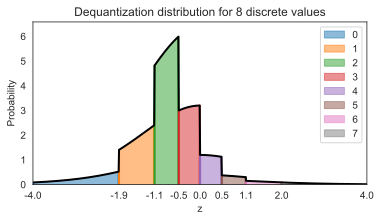

In [8]:
visualize_dequantization(quants=8, prior=np.array([0.075, 0.2, 0.4, 0.2, 0.075, 0.025, 0.0125, 0.0125]))

Transforming such a probability into a Gaussian is a difficult task, especially with such hard borders. Dequantization has therefore been extended to more sophisticated, learnable distributions beyond uniform in a variational framework. In particular, if we remember the learning objective $\log p(x) = \log \mathbb{E}_{u}\left[\frac{p(x+u)}{q(u|x)} \right]$, the uniform distribution can be replaced by a learned distribution $q_{\theta}(u|x)$ with support over $u\in[0,1)^D$. This approach is called Variational Dequantization and has been proposed by <span style="color:red">FLOW++ REFERNCE</span>. How can we learn such a distribution? We can use a second normalizing flow that takes $x$ as external input and learns a flexible distribution over $u$. To ensure a support over $[0,1)^D$, we can apply a sigmoid activation function as final flow transformation. 

Inheriting the original dequantization class, we can implement variational dequantization as follows: 

In [9]:
class VariationalDequantization(Dequantization):
    
    def __init__(self, var_flows, alpha=1e-5):
        """
        Inputs: 
            var_flows - A list of flow transformations to use for modeling q(u|x)
            alpha - Small constant, see Dequantization for details
        """
        super().__init__(alpha=alpha)
        self.flows = nn.ModuleList(var_flows)
        
    def dequant(self, z, ldj):
        z = z.to(torch.float32)
        img = (z / 255.0) * 2 - 1 # We condition the flows on x, i.e. the original image
        
        # Prior of u is a uniform distribution as before
        # As most flow transformations are defined on [-infinity,+infinity], we apply an inverse sigmoid first.
        deq_noise = torch.rand_like(z).detach()
        deq_noise, ldj = self.sigmoid(deq_noise, ldj, reverse=True)
        for flow in self.flows:
            deq_noise, ldj = flow(deq_noise, ldj, reverse=False, orig_img=img)
        deq_noise, ldj = self.sigmoid(deq_noise, ldj, reverse=False)
        
        # After the flows, apply u as in standard dequantization
        z = (z + deq_noise) / 256.0
        ldj -= np.log(256.0) * np.prod(z.shape[1:])
        return z, ldj

Variational dequantization can be used as a substitute for dequantization. We will compare dequantization and variational dequantization in later experiments. 

### Coupling layers

Next, we look at possible transformations to apply inside the flow. A recent popular flow layer, which works well in combination with deep neural networks, is the coupling layer introduced by <span style="color: red;">REF RealNVP</span>. The input $z$ is arbitrarily split into two parts, $z_{1:j}$ and $z_{j+1:d}$, of which the first remains unchanged by the flow. Yet, $z_{1:j}$ is used to parameterize the transformation for the second part, $z_{j+1:d}$. Various transformations have been proposed in recent time <span style="color: red;">REF Flow++, NormalizingFlowsOverview, NeuralSplineFlows</span>, but here we will settle for the simplest and most efficient one: affine coupling. In this coupling layer, we apply an affine transformation by shifting the input by a bias $\mu$ and scale it by $\sigma$. In other words, our transformation looks as follows:

$$z'_{j+1:d} = \mu_{\theta}(z_{1:j}) + \sigma_{\theta}(z_{1:j}) \odot z_{j+1:d}$$

The functions $\mu$ and $\sigma$ are implemented as a shared neural network. The LDJ is thereby the sum of the logs of the scaling factors. Inverting the layer can as simply be done as subtracting the bias and dividing by the scale: 

$$z_{j+1:d} = \left(z'_{j+1:d} - \mu_{\theta}(z_{1:j})\right) / \sigma_{\theta}(z_{1:j})$$

In our implementation, we will realize the splitting of variables as masking. The variables to be transformed, $z_{j+1:d}$, are masked when passing $z$ to the shared network to predict the transformation parameters. When applying the transformation, we mask the parameters for $z_{1:j}$ so that we have an identity operation for those variables:

In [10]:
class CouplingLayer(nn.Module):
    
    def __init__(self, network, mask, c_in):
        super().__init__()
        self.register_buffer('mask', mask)
        self.network = network
        self.scaling_factor = nn.Parameter(torch.zeros(c_in))
    
    def forward(self, z, ldj, reverse=False, orig_img=None):
        # Apply network to 
        z_in = z * self.mask
        if orig_img is None:
            nn_out = self.network(z_in)
        else:
            nn_out = self.network(torch.cat([z_in, orig_img], dim=1))
        s, t = nn_out.chunk(2, dim=1)
        
        # Stabilize scaling output
        s_fac = self.scaling_factor.exp().view(1, -1, 1, 1)
        s = torch.tanh(s / s_fac) * s_fac
        
        # Mask outputs (only transform the second part)
        s = s * (1 - self.mask)
        t = t * (1 - self.mask)
        
        # Affine transformation
        if not reverse:
            z = (z + t) * torch.exp(s)
            ldj += s.sum(dim=[1,2,3])
        else:
            z = (z * torch.exp(-s)) - t
            ldj -= s.sum(dim=[1,2,3])
            
        return z, ldj

For stabilization purposes, we apply a $\tanh$ activation function on the scaling output. This prevents sudden large output values for the scaling that can destabilize training. 

Coupling layers generalize to any masking technique we could think of. However, the most common approach for images is to split the input $z$ in half, using a checkerboard mask or channel mask. A checkerboard mask splits the variables across the height and width dimensions and assigns each other pixel to $z_{j+1:d}$. Thereby, the mask is shared across channels. In contrast, the channel mask assigns half of the channels to $z_{j+1:d}$, and the other half to $z_{1:j+1}$. Note that when we apply multiple coupling layers, we invert the masking for each other layer so that each variable is transformed a similar amount of times. 

Let's implement a function that creates a checkerboard mask and a channel mask for us:

In [11]:
def create_checkerboard_mask(h, w, invert=False):
    x, y = torch.arange(h, dtype=torch.int32), torch.arange(w, dtype=torch.int32)
    xx, yy = torch.meshgrid(x, y)
    mask = torch.fmod(xx + yy, 2)
    mask = mask.to(torch.float32).view(1, 1, h, w)
    if invert:
        mask = 1 - mask
    return mask

def create_channel_mask(c_in, invert=False):
    mask = torch.cat([torch.ones(c_in//2, dtype=torch.float32), 
                      torch.zeros(c_in-c_in//2, dtype=torch.float32)])
    mask = mask.view(1, c_in, 1, 1)
    if invert:
        mask = 1 - mask
    return mask

We can also visualize the corresponding masks for an image of size $8\times 8\times 2$ (2 channels):

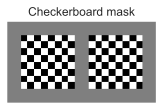

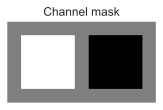

In [12]:
checkerboard_mask = create_checkerboard_mask(h=8, w=8).expand(-1,2,-1,-1)
channel_mask = create_channel_mask(c_in=2).expand(-1,-1,8,8)

show_imgs(checkerboard_mask.transpose(0,1), "Checkerboard mask")
show_imgs(channel_mask.transpose(0,1), "Channel mask")

As a last aspect of coupling layers, we need to decide for the deep neural network we want to apply in the coupling layers. The input to the layers is an image, and hence we stick with a CNN. Because the input to a transformation depends on all transformations before, it is crucial to ensure a good gradient flow through the CNN back to the input, which can be optimally achieved by a ResNet-like architecture. Specifically, we use a Gated ResNet that adds a $\sigma$-gate to the skip connection, similarly to the input gate in LSTMs. The details are not necessarily important here, and the network is strongly inspired from Flow++ <span style="color:red;">REF Flow++</span> in case you are interested in building even stronger models.

In [13]:
class ConcatELU(nn.Module):
    """
    Activation function that applies ELU in both direction (inverted and plain). 
    Allows non-linearity while providing strong gradients for any input (important for final convolution)
    """
    
    def forward(self, x):
        return torch.cat([F.elu(x), F.elu(-x)], dim=1)

    
class LayerNormChannels(nn.Module):
    
    def __init__(self, c_in):
        """
        This module applies layer norm across channels in an image. Has been shown to work well with ResNet connections.
        Inputs: 
            c_in - Number of channels of the input
        """
        super().__init__()
        self.layer_norm = nn.LayerNorm(c_in)
    
    def forward(self, x):
        x = x.permute(0, 2, 3, 1)
        x = self.layer_norm(x)
        x = x.permute(0, 3, 1, 2)
        return x

    
class GatedConv(nn.Module):
    
    def __init__(self, c_in, c_hidden):
        """
        This module applies a two-layer convolutional ResNet block with input gate
        Inputs:
            c_in - Number of channels of the input
            c_hidden - Number of hidden dimensions we want to model (usually similar to c_in)
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(c_in, c_hidden, kernel_size=3, padding=1),
            ConcatELU(),
            nn.Conv2d(2*c_hidden, 2*c_in, kernel_size=1)
        )
    
    def forward(self, x):
        out = self.net(x)
        val, gate = out.chunk(2, dim=1)
        return x + val * torch.sigmoid(gate)

    
class GatedConvNet(nn.Module):
    
    def __init__(self, c_in, c_hidden=32, c_out=-1, num_layers=3):
        """
        Module that summarizes the previous blocks to a full convolutional neural network.
        Inputs:
            c_in - Number of input channels
            c_hidden - Number of hidden dimensions to use within the network
            c_out - Number of output channels. If -1, 2 times the input channels are used (affine coupling)
            num_layers - Number of gated ResNet blocks to apply
        """
        super().__init__()
        c_out = c_out if c_out > 0 else 2 * c_in
        layers = []
        layers += [nn.Conv2d(c_in, c_hidden, kernel_size=3, padding=1)]
        for layer_index in range(num_layers):
            layers += [GatedConv(c_hidden, c_hidden),
                       LayerNormChannels(c_hidden)]
        layers += [ConcatELU(),
                   nn.Conv2d(2*c_hidden, c_out, kernel_size=3, padding=1)]
        self.nn = nn.Sequential(*layers)
        
        self.nn[-1].weight.data.zero_()
        self.nn[-1].bias.data.zero_()
    
    def forward(self, x):
        return self.nn(x)

### Training loop

Finally, we can add Dequantization, Variational Dequantization and Coupling Layers together to build our full normalizing flow on MNIST images. We apply 8 coupling layers in the main flow, and 4 for variational dequantization if applied. We apply a checkerboard mask throughout the network as with a single channel (black-white images), we cannot apply channel mask. 

In [15]:
def create_simple_flow(use_vardeq=True):
    flow_layers = []
    if use_vardeq:
        vardeq_layers = [CouplingLayer(network=GatedConvNet(c_in=2, c_out=2, c_hidden=16),
                                       mask=create_checkerboard_mask(h=28, w=28, invert=(i%2==1)),
                                       c_in=1) for i in range(4)]
        flow_layers += [VariationalDequantization(var_flows=vardeq_layers)]
    else:
        flow_layers += [Dequantization()]
    
    for i in range(8):
        flow_layers += [CouplingLayer(network=GatedConvNet(c_in=1, c_hidden=32),
                                      mask=create_checkerboard_mask(h=28, w=28, invert=(i%2==1)),
                                      c_in=1)]
        
    flow_model = ImageFlow(flow_layers).to(device)
    return flow_model

For implementing the training loop, we use the framework of PyTorch Lightning and reduce the code overhead. Note that we again provide pre-trained models (see later on in the notebook) as normalizing flows are particularly expensive to train. We have also run validation and testing as this can take some time as well with the added importance sampling.

In [14]:
def train_flow(flow, model_name="MNISTFlow"):
    # Create a PyTorch Lightning trainer
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, model_name), 
                         checkpoint_callback=ModelCheckpoint(save_weights_only=True),
                         gpus=1, 
                         max_epochs=200, 
                         gradient_clip_val=1.0,
                         callbacks=[LearningRateLogger("epoch")])
    train_data_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=8)
    result = None
    
    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, model_name + ".ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        ckpt = torch.load(pretrained_filename)
        flow.load_state_dict(ckpt['state_dict'])
        result = ckpt.get("result", None)
    else:
        print("Start training", model_name)
        trainer.fit(flow, train_data_loader, val_loader)
    
    # Test best model on validation and test set if no result has been found
    # Testing can be expensive due to the importance sampling.
    if result is None:
        val_result = trainer.test(flow, test_dataloaders=val_loader, verbose=not USE_NOTEBOOK)
        start_time = time.time()
        test_result = trainer.test(flow, test_dataloaders=test_loader, verbose=not USE_NOTEBOOK)
        duration = time.time() - start_time
        result = {"test": test_result, "val": val_result, "time": duration / len(test_loader) / flow.import_samples}
    
    return flow, result

## Multi-scale architecture

### Squeeze and Split

<img src="Squeeze_operation.svg" width="40%"/>

In [16]:
class SqueezeFlow(nn.Module):
    
    def forward(self, z, ldj, reverse=False):
        B, C, H, W = z.shape
        if not reverse:
            z = z.reshape(B, C, H//2, 2, W//2, 2)
            z = z.permute(0, 1, 3, 5, 2, 4)
            z = z.reshape(B, 4*C, H//2, W//2)
        else:
            z = z.reshape(B, C//4, 2, 2, H, W)
            z = z.permute(0, 1, 4, 2, 5, 3)
            z = z.reshape(B, C//4, H*2, W*2)
        return z, ldj

In [38]:
sq_flow = SqueezeFlow()
rand_img = torch.arange(1,17).view(1, 1, 4, 4)
print("Image (before)\n", rand_img)
forward_img, _ = sq_flow(rand_img, ldj=None, reverse=False)
print("\nImage (forward)\n", forward_img.permute(0,2,3,1)) # Permute for readability
reconst_img, _ = sq_flow(forward_img, ldj=None, reverse=True)
print("\nImage (reverse)\n", reconst_img)

Image (before)
 tensor([[[[ 1,  2,  3,  4],
          [ 5,  6,  7,  8],
          [ 9, 10, 11, 12],
          [13, 14, 15, 16]]]])

Image (forward)
 tensor([[[[ 1,  2,  5,  6],
          [ 3,  4,  7,  8]],

         [[ 9, 10, 13, 14],
          [11, 12, 15, 16]]]])

Image (reverse)
 tensor([[[[ 1,  2,  3,  4],
          [ 5,  6,  7,  8],
          [ 9, 10, 11, 12],
          [13, 14, 15, 16]]]])


In [18]:
class SplitFlow(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.prior = torch.distributions.normal.Normal(loc=0.0, scale=1.0)
    
    def forward(self, z, ldj, reverse=False):
        if not reverse:
            z, z_split = z.chunk(2, dim=1)
            ldj += self.prior.log_prob(z_split).sum(dim=[1,2,3])
        else:
            z_split = self.prior.sample(sample_shape=z.shape).to(device)
            z = torch.cat([z, z_split], dim=1)
            ldj -= self.prior.log_prob(z_split).sum(dim=[1,2,3])
        return z, ldj

In [19]:
def create_multiscale_flow():
    flow_layers = []
    
    vardeq_layers = [CouplingLayer(network=GatedConvNet(c_in=2, c_out=2, c_hidden=16),
                                   mask=create_checkerboard_mask(h=28, w=28, invert=(i%2==1)),
                                   c_in=1) for i in range(4)]
    flow_layers += [VariationalDequantization(vardeq_layers)]
    
    flow_layers += [CouplingLayer(network=GatedConvNet(c_in=1, c_hidden=32),
                                  mask=create_checkerboard_mask(h=28, w=28, invert=(i%2==1)),
                                  c_in=1) for i in range(2)]
    flow_layers += [SqueezeFlow()]
    for i in range(2):
        flow_layers += [CouplingLayer(network=GatedConvNet(c_in=4, c_hidden=48),
                                      mask=create_channel_mask(c_in=4, invert=(i%2==1)),
                                      c_in=4)]
    flow_layers += [SplitFlow(),
                    SqueezeFlow()]
    for i in range(4):
        flow_layers += [CouplingLayer(network=GatedConvNet(c_in=8, c_hidden=64),
                                      mask=create_channel_mask(c_in=8, invert=(i%2==1)),
                                      c_in=8)]

    flow_model = ImageFlow(flow_layers).to(device)
    return flow_model

In [20]:
def print_num_params(model):
    num_params = sum([np.prod(p.shape) for p in model.parameters()])
    print("Number of parameters: {:,}".format(num_params))

print_num_params(create_simple_flow(use_vardeq=False))
print_num_params(create_simple_flow(use_vardeq=True))
print_num_params(create_multiscale_flow())

Number of parameters: 335,128
Number of parameters: 379,556
Number of parameters: 1,062,090


### Training flow variants

In [21]:
flow_dict = {"simple": {}, "vardeq": {}, "multiscale": {}}
flow_dict["simple"]["model"], flow_dict["simple"]["result"] = train_flow(create_simple_flow(use_vardeq=False), model_name="MNISTFlow_simple")
flow_dict["vardeq"]["model"], flow_dict["vardeq"]["result"] = train_flow(create_simple_flow(use_vardeq=True), model_name="MNISTFlow_vardeq")
flow_dict["multiscale"]["model"], flow_dict["multiscale"]["result"] = train_flow(create_multiscale_flow(), model_name="MNISTFlow_multiscale")

GPU available: True, used: True
I0910 17:24:14.272925 140005084018496 distributed.py:41] GPU available: True, used: True
TPU available: False, using: 0 TPU cores
I0910 17:24:14.274633 140005084018496 distributed.py:41] TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
I0910 17:24:14.276465 140005084018496 distributed.py:41] CUDA_VISIBLE_DEVICES: [0]
GPU available: True, used: True
I0910 17:24:14.336973 140005084018496 distributed.py:41] GPU available: True, used: True
TPU available: False, using: 0 TPU cores
I0910 17:24:14.338386 140005084018496 distributed.py:41] TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
I0910 17:24:14.339472 140005084018496 distributed.py:41] CUDA_VISIBLE_DEVICES: [0]


Found pretrained model, loading...
Found pretrained model, loading...


GPU available: True, used: True
I0910 17:24:14.400318 140005084018496 distributed.py:41] GPU available: True, used: True
TPU available: False, using: 0 TPU cores
I0910 17:24:14.401782 140005084018496 distributed.py:41] TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
I0910 17:24:14.402786 140005084018496 distributed.py:41] CUDA_VISIBLE_DEVICES: [0]


Found pretrained model, loading...


## Analysing the flows

### Density modeling and sampling

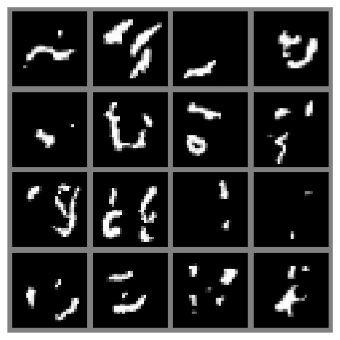

In [22]:
pl.seed_everything(44)
samples = flow_dict["simple"]["model"].sample(img_shape=[16,1,28,28])
show_imgs(samples.cpu())

/home/phillip/anaconda3/envs/nlp1/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Mixed memory format inputs detected while calling the operator. The operator will output contiguous tensor even if some of the inputs are in channels_last format. (Triggered internally at  /pytorch/aten/src/ATen/native/TensorIterator.cpp:918.)


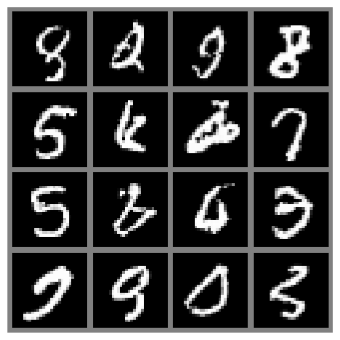

In [23]:
pl.seed_everything(44)
samples = flow_dict["multiscale"]["model"].sample(img_shape=[16,8,7,7])
show_imgs(samples.cpu())

In [37]:
%%html
<!-- Some HTML code to increase font size in the following table -->
<style>
th {font-size: 120%;}
td {font-size: 120%;}
</style>

In [35]:
import tabulate
table = [[key, 
          "%4.3f bpd" % flow_dict[key]["result"]["val"][0]["test_bpd"], 
          "%4.3f bpd" % flow_dict[key]["result"]["test"][0]["test_bpd"], 
          "%2.0f ms" % (1000 * flow_dict[key]["result"]["time"]),
          "{:,}".format(sum([np.prod(p.shape) for p in flow_dict[key]["model"].parameters()]))] 
         for key in flow_dict]
tabulate.tabulate(table, tablefmt='html', headers=["Model", "Validation Bpd", "Test Bpd", "Inference time", "Num Parameters"])

Model,Validation Bpd,Test Bpd,Inference time,Num Parameters
simple,1.109 bpd,1.107 bpd,51 ms,"335,128"
vardeq,1.068 bpd,1.066 bpd,69 ms,"379,556"
multiscale,1.029 bpd,1.026 bpd,40 ms,"1,062,090"


### Interpolation in latent space

Take two training images, and interpolate between their latent space

In [26]:
@torch.no_grad()
def interpolate(model, img1, img2):
    imgs = torch.stack([img1, img2], dim=0).to(model.device)
    z, _ = model.encode(imgs)
    alpha = torch.linspace(0, 1, steps=8, device=z.device).view(-1, 1, 1, 1)
    interpolations = z[0:1] * alpha + z[1:2] * (1 - alpha)
    interp_imgs = model.sample(interpolations.shape[:1] + imgs.shape[1:], z_init=interpolations)
    show_imgs(interp_imgs)

exmp_imgs, _ = next(iter(train_loader))

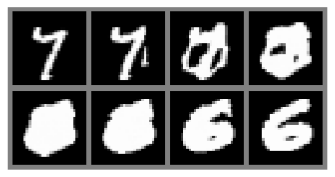

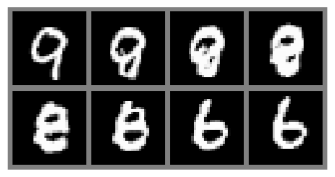

In [27]:
pl.seed_everything(42)
for i in range(2):
    interpolate(flow_dict["vardeq"]["model"], exmp_imgs[2*i], exmp_imgs[2*i+1])

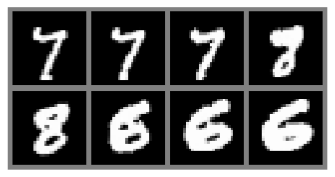

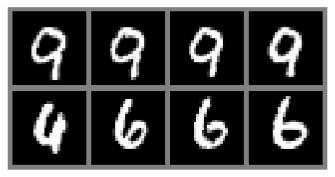

In [28]:
pl.seed_everything(42)
for i in range(2):
    interpolate(flow_dict["multiscale"]["model"], exmp_imgs[2*i], exmp_imgs[2*i+1])

### Visualization of latents in different levels of multi-scale
Sample from higher level and show how images change or not

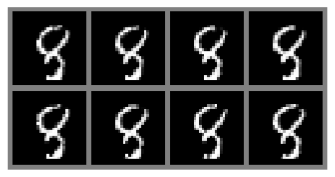

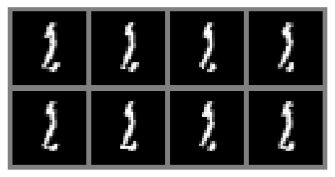

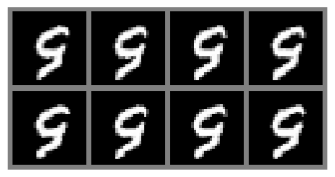

In [29]:
pl.seed_everything(44)
for _ in range(3):
    z_init = flow_dict["multiscale"]["model"].prior.sample(sample_shape=[1,8,7,7])
    z_init = z_init.expand(8, -1, -1, -1)
    samples = flow_dict["multiscale"]["model"].sample(img_shape=z_init.shape, z_init=z_init)
    show_imgs(samples.cpu())

### Visualizing Dequantization

In [30]:
def visualize_dequant_distribution(model, imgs):
    imgs = imgs.to(device)
    ldj = torch.zeros(imgs.shape[0], dtype=torch.float32).to(device)
    with torch.no_grad():
        dequant_vals = []
        for _ in range(8):
            d, _ = model.flows[0](imgs, ldj, reverse=False)
            dequant_vals.append(d)
        dequant_vals = torch.cat(dequant_vals, dim=0)
    dequant_vals = dequant_vals.view(-1).cpu().numpy()
    sns.set()
    plt.figure(figsize=(10,3))
    plt.hist(dequant_vals, bins=256, color=to_rgb("C0")+(0.5,), edgecolor="C0", density=True)
    plt.show()
    plt.close()

In [31]:
sample_imgs, _ = next(iter(train_loader))

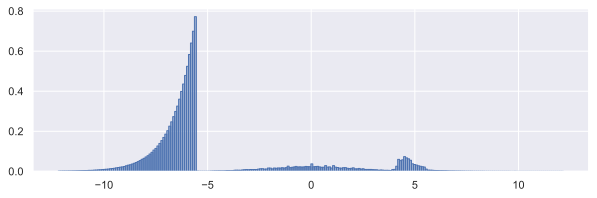

In [32]:
visualize_dequant_distribution(flow_dict["simple"]["model"], sample_imgs)

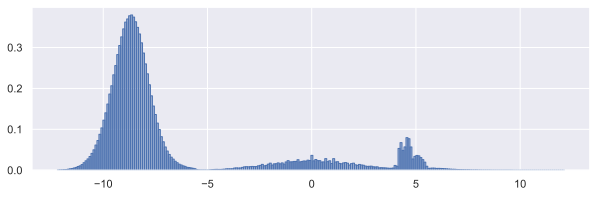

In [33]:
visualize_dequant_distribution(flow_dict["vardeq"]["model"], sample_imgs)

## Conclusion

## References

[3] Domke, Justin, and Scheldon, Daniel (2018). "Importance Weighting and Variational Inference." In: Proceedings to the 32nd Conference on Neural Information Processing Systems, Montreal, Canada. [Link](https://papers.nips.cc/paper/7699-importance-weighting-and-variational-inference.pdf)